In [1]:
import os
os.chdir("../..")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils.dataset_loader import *
from utils.model_utils import *
from utils.train_utils import *
from utils.metrics import *
from utils.visualization import *
import optuna
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [4]:
os.makedirs("outputs/models", exist_ok=True)
os.makedirs("outputs/plots", exist_ok=True)

In [5]:
print("[INFO] Loading datasets...")
train_loader, val_loader, test_loader = load_datasets(
    "wildfire_dataset_scaled", batch_size=8, augmentation="augmented"
)
print("[INFO] Datasets loaded successfully!")

2024-12-24 19:16:13,656 - INFO - Loading datasets from wildfire_dataset_scaled with augmentation type 'augmented'.
2024-12-24 19:16:13,656 - INFO - Applying selected augmentations for wildfire scenarios.
2024-12-24 19:16:13,665 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/train
2024-12-24 19:16:13,667 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/val
2024-12-24 19:16:13,668 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/test
2024-12-24 19:16:13,669 - INFO - Datasets initialized. Preparing DataLoaders...
2024-12-24 19:16:13,669 - INFO - Using WeightedRandomSampler for class balancing.
2024-12-24 19:16:13,669 - INFO - Computing class weights from directory: wildfire_dataset_scaled/train
2024-12-24 19:16:13,671 - INFO - Class 'fire' has 730 samples.
2024-12-24 19:16:13,672 - INFO - Class 'nofire' has 1157 samples.
2024-12-24 19:16:13,673 - INFO - Computed class weights: {'fire': 1.0, 'nofire': 

[INFO] Loading datasets...


2024-12-24 19:16:20,246 - INFO - DataLoaders created successfully.


[INFO] Datasets loaded successfully!


In [6]:
def objective(trial):
    print(f"[DEBUG] Starting trial {trial.number}...")

    # Hyperparameter suggestions
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])
    print(f"[DEBUG] Suggested hyperparameters: lr={lr}, weight_decay={weight_decay}, optimizer={optimizer_name}")

    # Initialize model
    print("[DEBUG] Initializing convnext_tiny model...")
    model = initialize_model("convnext_tiny", num_classes=2, pretrained=True, freeze_all=False, unfreeze_last_n=12)
    model.to(device)

    # Optimizer setup
    print("[DEBUG] Setting up optimizer...")
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.5)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Train the model
    print("[INFO] Starting model training...")
    save_path = "outputs/models/tuned/convnext_tiny_trial_best.pth"
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        save_path=save_path,
        early_stop_patience=5,
        monitor_metric="val_f1",
    )
    print("[INFO] Training completed!")

    # Return validation recall
    val_recall = history["val_f1"][-1]
    print(f"[INFO] Trial {trial.number} - Final Validation F1: {val_recall:.4f}")
    return val_recall


In [7]:
# Run Optuna

import time

# Start the timer
start_time = time.time()
print("Trials started...")


print("[INFO] Running hyperparameter optimization...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print(f"[INFO] Best parameters found: {study.best_params}")

# Calculate and display elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Format elapsed time as hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Trials completed in {hours} hours, {minutes} minutes, and {seconds} seconds.")


[I 2024-12-24 19:16:20,258] A new study created in memory with name: no-name-f350d608-68e5-4af0-9250-d7b2bda283b0


Trials started...
[INFO] Running hyperparameter optimization...
[DEBUG] Starting trial 0...
[DEBUG] Suggested hyperparameters: lr=0.0005869782588421199, weight_decay=9.044740271496002e-05, optimizer=SGD
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000587
[INFO] Best model saved with val_f1: 0.7178
Epoch [1]: Train Loss: 0.4803, Train Acc: 0.7806 | Val Loss: 0.5803, Val Acc: 0.7164, Val Recall: 0.5894, Val F1: 0.7178


[INFO] Learning rate adjusted to: 0.000587
[INFO] Best model saved with val_f1: 0.8867
Epoch [2]: Train Loss: 0.3530, Train Acc: 0.8569 | Val Loss: 0.3314, Val Acc: 0.8582, Val Recall: 0.9065, Val F1: 0.8867


[INFO] Learning rate adjusted to: 0.000587
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [3]: Train Loss: 0.2813, Train Acc: 0.8855 | Val Loss: 0.3588, Val Acc: 0.8557, Val Recall: 0.8252, Val F1: 0.8750


[INFO] Learning rate adjusted to: 0.000587
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [4]: Train Loss: 0.2791, Train Acc: 0.8871 | Val Loss: 0.3177, Val Acc: 0.8532, Val Recall: 0.8171, Val F1: 0.8720


[INFO] Learning rate adjusted to: 0.000587
[INFO] Best model saved with val_f1: 0.9102
Epoch [5]: Train Loss: 0.2237, Train Acc: 0.9152 | Val Loss: 0.2732, Val Acc: 0.8856, Val Recall: 0.9472, Val F1: 0.9102


[INFO] Learning rate adjusted to: 0.000587
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.2072, Train Acc: 0.9152 | Val Loss: 0.3427, Val Acc: 0.8806, Val Recall: 0.9024, Val F1: 0.9024


[INFO] Learning rate adjusted to: 0.000587
[INFO] Best model saved with val_f1: 0.9393
Epoch [7]: Train Loss: 0.1859, Train Acc: 0.9237 | Val Loss: 0.2148, Val Acc: 0.9254, Val Recall: 0.9431, Val F1: 0.9393


[INFO] Learning rate adjusted to: 0.000587
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.1766, Train Acc: 0.9364 | Val Loss: 0.2409, Val Acc: 0.9080, Val Recall: 0.9268, Val F1: 0.9249


[INFO] Learning rate adjusted to: 0.000587
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [9]: Train Loss: 0.1346, Train Acc: 0.9465 | Val Loss: 0.2562, Val Acc: 0.9055, Val Recall: 0.9634, Val F1: 0.9258


[INFO] Learning rate adjusted to: 0.000587
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [10]: Train Loss: 0.1420, Train Acc: 0.9433 | Val Loss: 0.2254, Val Acc: 0.9204, Val Recall: 0.9715, Val F1: 0.9373


[INFO] Learning rate adjusted to: 0.000293
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [11]: Train Loss: 0.1127, Train Acc: 0.9608 | Val Loss: 0.2938, Val Acc: 0.9104, Val Recall: 0.9106, Val F1: 0.9256


[I 2024-12-24 19:22:43,716] Trial 0 finished with value: 0.9288537549407114 and parameters: {'lr': 0.0005869782588421199, 'weight_decay': 9.044740271496002e-05, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.9288537549407114.


[INFO] Learning rate adjusted to: 0.000293
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [12]: Train Loss: 0.0799, Train Acc: 0.9709 | Val Loss: 0.3104, Val Acc: 0.9104, Val Recall: 0.9553, Val F1: 0.9289
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 12 epochs. Best val_f1: 0.9393

[INFO] Training completed!
[INFO] Trial 0 - Final Validation F1: 0.9289
[DEBUG] Starting trial 1...
[DEBUG] Suggested hyperparameters: lr=6.0187520008194326e-05, weight_decay=0.0007060131907901912, optimizer=SGD
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000060
[INFO] Best model saved with val_f1: 0.8627
Epoch [1]: Train Loss: 0.6524, Train Acc: 0.6820 | Val Loss: 0.6035, Val Acc: 0.8234, Val Recall: 0.9065, Val F1: 0.8627


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [2]: Train Loss: 0.5508, Train Acc: 0.7960 | Val Loss: 0.4613, Val Acc: 0.8284, Val Recall: 0.8618, Val F1: 0.8600


[INFO] Learning rate adjusted to: 0.000060
[INFO] Best model saved with val_f1: 0.8863
Epoch [3]: Train Loss: 0.4197, Train Acc: 0.8278 | Val Loss: 0.3682, Val Acc: 0.8557, Val Recall: 0.9187, Val F1: 0.8863


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.3532, Train Acc: 0.8622 | Val Loss: 0.4715, Val Acc: 0.7786, Val Recall: 0.6707, Val F1: 0.7876


[INFO] Learning rate adjusted to: 0.000060
[INFO] Best model saved with val_f1: 0.9084
Epoch [5]: Train Loss: 0.3300, Train Acc: 0.8718 | Val Loss: 0.2894, Val Acc: 0.8831, Val Recall: 0.9472, Val F1: 0.9084


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.3004, Train Acc: 0.8813 | Val Loss: 0.3571, Val Acc: 0.8433, Val Recall: 0.7805, Val F1: 0.8591


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [7]: Train Loss: 0.2538, Train Acc: 0.9131 | Val Loss: 0.3675, Val Acc: 0.8383, Val Recall: 0.7764, Val F1: 0.8546


[INFO] Learning rate adjusted to: 0.000060
[INFO] Best model saved with val_f1: 0.9098
Epoch [8]: Train Loss: 0.2440, Train Acc: 0.9110 | Val Loss: 0.2580, Val Acc: 0.8881, Val Recall: 0.9228, Val F1: 0.9098


[INFO] Learning rate adjusted to: 0.000060
[INFO] Best model saved with val_f1: 0.9237
Epoch [9]: Train Loss: 0.2428, Train Acc: 0.9110 | Val Loss: 0.2607, Val Acc: 0.9030, Val Recall: 0.9593, Val F1: 0.9237


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [10]: Train Loss: 0.2284, Train Acc: 0.9141 | Val Loss: 0.2415, Val Acc: 0.9030, Val Recall: 0.9390, Val F1: 0.9222


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [11]: Train Loss: 0.1943, Train Acc: 0.9322 | Val Loss: 0.2491, Val Acc: 0.8980, Val Recall: 0.9715, Val F1: 0.9210


[INFO] Learning rate adjusted to: 0.000060
[INFO] Best model saved with val_f1: 0.9310
Epoch [12]: Train Loss: 0.2044, Train Acc: 0.9359 | Val Loss: 0.2329, Val Acc: 0.9129, Val Recall: 0.9593, Val F1: 0.9310


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [13]: Train Loss: 0.1652, Train Acc: 0.9438 | Val Loss: 0.2378, Val Acc: 0.9080, Val Recall: 0.9268, Val F1: 0.9249


[INFO] Learning rate adjusted to: 0.000060
[INFO] Best model saved with val_f1: 0.9317
Epoch [14]: Train Loss: 0.1765, Train Acc: 0.9406 | Val Loss: 0.2173, Val Acc: 0.9154, Val Recall: 0.9431, Val F1: 0.9317


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [15]: Train Loss: 0.1537, Train Acc: 0.9512 | Val Loss: 0.2303, Val Acc: 0.9104, Val Recall: 0.9553, Val F1: 0.9289


[INFO] Learning rate adjusted to: 0.000060
[INFO] Best model saved with val_f1: 0.9320
Epoch [16]: Train Loss: 0.1501, Train Acc: 0.9502 | Val Loss: 0.2053, Val Acc: 0.9154, Val Recall: 0.9472, Val F1: 0.9320


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [17]: Train Loss: 0.1538, Train Acc: 0.9449 | Val Loss: 0.2575, Val Acc: 0.8905, Val Recall: 0.9228, Val F1: 0.9116


[INFO] Learning rate adjusted to: 0.000060
[INFO] Best model saved with val_f1: 0.9352
Epoch [18]: Train Loss: 0.1526, Train Acc: 0.9465 | Val Loss: 0.2359, Val Acc: 0.9179, Val Recall: 0.9675, Val F1: 0.9352


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [19]: Train Loss: 0.1285, Train Acc: 0.9571 | Val Loss: 0.3566, Val Acc: 0.8856, Val Recall: 0.9837, Val F1: 0.9132


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [20]: Train Loss: 0.1239, Train Acc: 0.9603 | Val Loss: 0.2431, Val Acc: 0.9179, Val Recall: 0.9553, Val F1: 0.9344


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [21]: Train Loss: 0.1151, Train Acc: 0.9613 | Val Loss: 0.2344, Val Acc: 0.9129, Val Recall: 0.9390, Val F1: 0.9296


[INFO] Learning rate adjusted to: 0.000030
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [22]: Train Loss: 0.1181, Train Acc: 0.9618 | Val Loss: 0.2613, Val Acc: 0.9154, Val Recall: 0.9065, Val F1: 0.9292


[INFO] Learning rate adjusted to: 0.000030
[INFO] Best model saved with val_f1: 0.9400
Epoch [23]: Train Loss: 0.0986, Train Acc: 0.9677 | Val Loss: 0.2140, Val Acc: 0.9254, Val Recall: 0.9553, Val F1: 0.9400


[INFO] Learning rate adjusted to: 0.000030
[INFO] Best model saved with val_f1: 0.9407
Epoch [24]: Train Loss: 0.0925, Train Acc: 0.9740 | Val Loss: 0.2301, Val Acc: 0.9254, Val Recall: 0.9675, Val F1: 0.9407


[INFO] Learning rate adjusted to: 0.000030
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [25]: Train Loss: 0.1020, Train Acc: 0.9687 | Val Loss: 0.2445, Val Acc: 0.9154, Val Recall: 0.9634, Val F1: 0.9331


[INFO] Learning rate adjusted to: 0.000030
[INFO] Best model saved with val_f1: 0.9438
Epoch [26]: Train Loss: 0.1040, Train Acc: 0.9693 | Val Loss: 0.2095, Val Acc: 0.9303, Val Recall: 0.9553, Val F1: 0.9438


[INFO] Learning rate adjusted to: 0.000030
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [27]: Train Loss: 0.0873, Train Acc: 0.9709 | Val Loss: 0.2452, Val Acc: 0.9080, Val Recall: 0.9024, Val F1: 0.9231


[INFO] Learning rate adjusted to: 0.000030
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [28]: Train Loss: 0.0738, Train Acc: 0.9830 | Val Loss: 0.2435, Val Acc: 0.9104, Val Recall: 0.9065, Val F1: 0.9253


[INFO] Learning rate adjusted to: 0.000030
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [29]: Train Loss: 0.0804, Train Acc: 0.9756 | Val Loss: 0.2353, Val Acc: 0.9254, Val Recall: 0.9553, Val F1: 0.9400


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [30]: Train Loss: 0.0875, Train Acc: 0.9730 | Val Loss: 0.2237, Val Acc: 0.9254, Val Recall: 0.9593, Val F1: 0.9402


[I 2024-12-24 19:39:42,808] Trial 1 finished with value: 0.9378757515030061 and parameters: {'lr': 6.0187520008194326e-05, 'weight_decay': 0.0007060131907901912, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.9378757515030061.


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [31]: Train Loss: 0.0616, Train Acc: 0.9815 | Val Loss: 0.2486, Val Acc: 0.9229, Val Recall: 0.9512, Val F1: 0.9379
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 31 epochs. Best val_f1: 0.9438

[INFO] Training completed!
[INFO] Trial 1 - Final Validation F1: 0.9379
[DEBUG] Starting trial 2...
[DEBUG] Suggested hyperparameters: lr=0.005294071095114733, weight_decay=7.220380383513963e-05, optimizer=AdamW
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.005294
[INFO] Best model saved with val_f1: 0.7593
Epoch [1]: Train Loss: 1.1003, Train Acc: 0.5019 | Val Loss: 0.7865, Val Acc: 0.6119, Val Recall: 1.0000, Val F1: 0.7593


[INFO] Learning rate adjusted to: 0.005294
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [2]: Train Loss: 1.0281, Train Acc: 0.5040 | Val Loss: 0.6686, Val Acc: 0.6119, Val Recall: 1.0000, Val F1: 0.7593


[INFO] Learning rate adjusted to: 0.005294
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [3]: Train Loss: 0.7393, Train Acc: 0.5294 | Val Loss: 0.7300, Val Acc: 0.6119, Val Recall: 1.0000, Val F1: 0.7593


[INFO] Learning rate adjusted to: 0.005294
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [4]: Train Loss: 0.7324, Train Acc: 0.5140 | Val Loss: 0.6764, Val Acc: 0.6119, Val Recall: 1.0000, Val F1: 0.7593


[INFO] Learning rate adjusted to: 0.002647
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [5]: Train Loss: 0.7125, Train Acc: 0.5236 | Val Loss: 0.6773, Val Acc: 0.6119, Val Recall: 1.0000, Val F1: 0.7593


[I 2024-12-24 19:43:06,060] Trial 2 finished with value: 0.7592592592592593 and parameters: {'lr': 0.005294071095114733, 'weight_decay': 7.220380383513963e-05, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.9378757515030061.


[INFO] Learning rate adjusted to: 0.002647
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [6]: Train Loss: 0.6970, Train Acc: 0.5374 | Val Loss: 0.6779, Val Acc: 0.6119, Val Recall: 1.0000, Val F1: 0.7593
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 6 epochs. Best val_f1: 0.7593

[INFO] Training completed!
[INFO] Trial 2 - Final Validation F1: 0.7593
[DEBUG] Starting trial 3...
[DEBUG] Suggested hyperparameters: lr=8.26702778998642e-05, weight_decay=1.2928068483390614e-05, optimizer=Adam
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000083
[INFO] Best model saved with val_f1: 0.9099
Epoch [1]: Train Loss: 0.3352, Train Acc: 0.8543 | Val Loss: 0.2503, Val Acc: 0.8930, Val Recall: 0.8821, Val F1: 0.9099


[INFO] Learning rate adjusted to: 0.000083
[INFO] Best model saved with val_f1: 0.9234
Epoch [2]: Train Loss: 0.1379, Train Acc: 0.9518 | Val Loss: 0.2074, Val Acc: 0.9080, Val Recall: 0.9065, Val F1: 0.9234


[INFO] Learning rate adjusted to: 0.000083
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [3]: Train Loss: 0.0917, Train Acc: 0.9682 | Val Loss: 0.3594, Val Acc: 0.8881, Val Recall: 0.9634, Val F1: 0.9133


[INFO] Learning rate adjusted to: 0.000083
[INFO] Best model saved with val_f1: 0.9438
Epoch [4]: Train Loss: 0.0768, Train Acc: 0.9687 | Val Loss: 0.2243, Val Acc: 0.9303, Val Recall: 0.9553, Val F1: 0.9438


[INFO] Learning rate adjusted to: 0.000083
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.0578, Train Acc: 0.9799 | Val Loss: 0.2416, Val Acc: 0.9279, Val Recall: 0.9350, Val F1: 0.9407


[INFO] Learning rate adjusted to: 0.000083
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [6]: Train Loss: 0.0478, Train Acc: 0.9846 | Val Loss: 0.3401, Val Acc: 0.9303, Val Recall: 0.9553, Val F1: 0.9438


[INFO] Learning rate adjusted to: 0.000083
[INFO] Best model saved with val_f1: 0.9480
Epoch [7]: Train Loss: 0.0473, Train Acc: 0.9852 | Val Loss: 0.2773, Val Acc: 0.9353, Val Recall: 0.9634, Val F1: 0.9480


[INFO] Learning rate adjusted to: 0.000083
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.0512, Train Acc: 0.9825 | Val Loss: 0.2513, Val Acc: 0.9229, Val Recall: 0.9024, Val F1: 0.9347


[INFO] Learning rate adjusted to: 0.000083
[INFO] Best model saved with val_f1: 0.9487
Epoch [9]: Train Loss: 0.0352, Train Acc: 0.9873 | Val Loss: 0.2671, Val Acc: 0.9378, Val Recall: 0.9390, Val F1: 0.9487


[INFO] Learning rate adjusted to: 0.000083
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [10]: Train Loss: 0.0311, Train Acc: 0.9910 | Val Loss: 0.2258, Val Acc: 0.9353, Val Recall: 0.9553, Val F1: 0.9476


[INFO] Learning rate adjusted to: 0.000083
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [11]: Train Loss: 0.0202, Train Acc: 0.9952 | Val Loss: 0.3299, Val Acc: 0.9129, Val Recall: 0.9350, Val F1: 0.9293


[INFO] Learning rate adjusted to: 0.000083
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [12]: Train Loss: 0.0398, Train Acc: 0.9889 | Val Loss: 0.2642, Val Acc: 0.9179, Val Recall: 0.9187, Val F1: 0.9320


[INFO] Learning rate adjusted to: 0.000041
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [13]: Train Loss: 0.0093, Train Acc: 0.9984 | Val Loss: 0.3298, Val Acc: 0.9254, Val Recall: 0.9390, Val F1: 0.9390


[I 2024-12-24 19:51:33,259] Trial 3 finished with value: 0.937984496124031 and parameters: {'lr': 8.26702778998642e-05, 'weight_decay': 1.2928068483390614e-05, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.937984496124031.


[INFO] Learning rate adjusted to: 0.000041
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [14]: Train Loss: 0.0041, Train Acc: 0.9984 | Val Loss: 0.4375, Val Acc: 0.9204, Val Recall: 0.9837, Val F1: 0.9380
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 14 epochs. Best val_f1: 0.9487

[INFO] Training completed!
[INFO] Trial 3 - Final Validation F1: 0.9380
[DEBUG] Starting trial 4...
[DEBUG] Suggested hyperparameters: lr=0.00229244416583856, weight_decay=1.4726747865018038e-05, optimizer=SGD
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.002292
[INFO] Best model saved with val_f1: 0.5915
Epoch [1]: Train Loss: 0.6517, Train Acc: 0.6121 | Val Loss: 0.6496, Val Acc: 0.5945, Val Recall: 0.4797, Val F1: 0.5915


[INFO] Learning rate adjusted to: 0.002292
[INFO] Best model saved with val_f1: 0.8318
Epoch [2]: Train Loss: 0.5866, Train Acc: 0.6757 | Val Loss: 0.4650, Val Acc: 0.7687, Val Recall: 0.9350, Val F1: 0.8318


[INFO] Learning rate adjusted to: 0.002292
[INFO] Best model saved with val_f1: 0.8543
Epoch [3]: Train Loss: 0.4798, Train Acc: 0.7716 | Val Loss: 0.4022, Val Acc: 0.8209, Val Recall: 0.8577, Val F1: 0.8543


[INFO] Learning rate adjusted to: 0.002292
[INFO] Best model saved with val_f1: 0.8849
Epoch [4]: Train Loss: 0.4174, Train Acc: 0.8082 | Val Loss: 0.3234, Val Acc: 0.8557, Val Recall: 0.9065, Val F1: 0.8849


[INFO] Learning rate adjusted to: 0.002292
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.3577, Train Acc: 0.8453 | Val Loss: 0.3377, Val Acc: 0.8458, Val Recall: 0.9024, Val F1: 0.8775


[INFO] Learning rate adjusted to: 0.002292
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [6]: Train Loss: 0.3058, Train Acc: 0.8601 | Val Loss: 0.4050, Val Acc: 0.8408, Val Recall: 0.7764, Val F1: 0.8565


[INFO] Learning rate adjusted to: 0.002292
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [7]: Train Loss: 0.3181, Train Acc: 0.8654 | Val Loss: 0.4516, Val Acc: 0.7985, Val Recall: 0.6992, Val F1: 0.8094


[INFO] Learning rate adjusted to: 0.002292
[INFO] Best model saved with val_f1: 0.9069
Epoch [8]: Train Loss: 0.2776, Train Acc: 0.8824 | Val Loss: 0.3111, Val Acc: 0.8856, Val Recall: 0.9106, Val F1: 0.9069


[INFO] Learning rate adjusted to: 0.002292
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [9]: Train Loss: 0.2401, Train Acc: 0.8988 | Val Loss: 0.3066, Val Acc: 0.8756, Val Recall: 0.9350, Val F1: 0.9020


[INFO] Learning rate adjusted to: 0.002292
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [10]: Train Loss: 0.2376, Train Acc: 0.9089 | Val Loss: 0.3523, Val Acc: 0.8682, Val Recall: 0.8577, Val F1: 0.8884


[INFO] Learning rate adjusted to: 0.002292
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [11]: Train Loss: 0.2313, Train Acc: 0.9030 | Val Loss: 0.3124, Val Acc: 0.8756, Val Recall: 0.8821, Val F1: 0.8967


[INFO] Learning rate adjusted to: 0.001146
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [12]: Train Loss: 0.1867, Train Acc: 0.9221 | Val Loss: 0.3997, Val Acc: 0.8234, Val Recall: 0.7805, Val F1: 0.8440


[I 2024-12-24 19:58:37,927] Trial 4 finished with value: 0.9019607843137255 and parameters: {'lr': 0.00229244416583856, 'weight_decay': 1.4726747865018038e-05, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.937984496124031.


[INFO] Learning rate adjusted to: 0.001146
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [13]: Train Loss: 0.1609, Train Acc: 0.9364 | Val Loss: 0.3432, Val Acc: 0.8881, Val Recall: 0.8415, Val F1: 0.9020
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 13 epochs. Best val_f1: 0.9069

[INFO] Training completed!
[INFO] Trial 4 - Final Validation F1: 0.9020
[DEBUG] Starting trial 5...
[DEBUG] Suggested hyperparameters: lr=0.008470424571887292, weight_decay=0.000529361151645977, optimizer=SGD
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.008470
[INFO] Best model saved with val_f1: 0.6916
Epoch [1]: Train Loss: 0.8724, Train Acc: 0.5448 | Val Loss: 0.6248, Val Acc: 0.6517, Val Recall: 0.6382, Val F1: 0.6916


[INFO] Learning rate adjusted to: 0.008470
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [2]: Train Loss: 1.2267, Train Acc: 0.5692 | Val Loss: 3.6385, Val Acc: 0.3881, Val Recall: 0.0000, Val F1: 0.0000


[INFO] Learning rate adjusted to: 0.008470
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [3]: Train Loss: 0.9732, Train Acc: 0.5495 | Val Loss: 0.7261, Val Acc: 0.5373, Val Recall: 0.3943, Val F1: 0.5105


[INFO] Learning rate adjusted to: 0.008470
[INFO] Best model saved with val_f1: 0.7425
Epoch [4]: Train Loss: 0.7104, Train Acc: 0.5824 | Val Loss: 0.6431, Val Acc: 0.6567, Val Recall: 0.8089, Val F1: 0.7425


[INFO] Learning rate adjusted to: 0.008470
[INFO] Best model saved with val_f1: 0.7560
Epoch [5]: Train Loss: 0.6951, Train Acc: 0.5999 | Val Loss: 0.6561, Val Acc: 0.6194, Val Recall: 0.9634, Val F1: 0.7560


[INFO] Learning rate adjusted to: 0.008470
[INFO] Best model saved with val_f1: 0.7640
Epoch [6]: Train Loss: 0.6746, Train Acc: 0.6105 | Val Loss: 0.6156, Val Acc: 0.6542, Val Recall: 0.9146, Val F1: 0.7640


[INFO] Learning rate adjusted to: 0.008470
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.7087, Train Acc: 0.6131 | Val Loss: 0.6304, Val Acc: 0.6343, Val Recall: 0.6341, Val F1: 0.6797


[INFO] Learning rate adjusted to: 0.008470
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [8]: Train Loss: 0.6820, Train Acc: 0.6105 | Val Loss: 0.6187, Val Acc: 0.6318, Val Recall: 0.6260, Val F1: 0.6754


[INFO] Learning rate adjusted to: 0.008470
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [9]: Train Loss: 0.6400, Train Acc: 0.6290 | Val Loss: 0.6544, Val Acc: 0.6119, Val Recall: 1.0000, Val F1: 0.7593


[INFO] Learning rate adjusted to: 0.004235
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [10]: Train Loss: 0.6349, Train Acc: 0.6407 | Val Loss: 0.6139, Val Acc: 0.6070, Val Recall: 0.6138, Val F1: 0.6565


[I 2024-12-24 20:04:36,263] Trial 5 finished with value: 0.6091370558375635 and parameters: {'lr': 0.008470424571887292, 'weight_decay': 0.000529361151645977, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.937984496124031.


[INFO] Learning rate adjusted to: 0.004235
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [11]: Train Loss: 0.6084, Train Acc: 0.6587 | Val Loss: 0.6024, Val Acc: 0.6169, Val Recall: 0.4878, Val F1: 0.6091
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 11 epochs. Best val_f1: 0.7640

[INFO] Training completed!
[INFO] Trial 5 - Final Validation F1: 0.6091
[DEBUG] Starting trial 6...
[DEBUG] Suggested hyperparameters: lr=0.00023535529415904405, weight_decay=0.0007260932932582955, optimizer=AdamW
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000235
[INFO] Best model saved with val_f1: 0.8322
Epoch [1]: Train Loss: 0.3769, Train Acc: 0.8336 | Val Loss: 0.4615, Val Acc: 0.8085, Val Recall: 0.7764, Val F1: 0.8322


[INFO] Learning rate adjusted to: 0.000235
[INFO] Best model saved with val_f1: 0.8822
Epoch [2]: Train Loss: 0.2135, Train Acc: 0.9152 | Val Loss: 0.4290, Val Acc: 0.8632, Val Recall: 0.8374, Val F1: 0.8822


[INFO] Learning rate adjusted to: 0.000235
[INFO] Best model saved with val_f1: 0.9461
Epoch [3]: Train Loss: 0.1559, Train Acc: 0.9444 | Val Loss: 0.2499, Val Acc: 0.9328, Val Recall: 0.9634, Val F1: 0.9461


[INFO] Learning rate adjusted to: 0.000235
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.1453, Train Acc: 0.9491 | Val Loss: 0.2890, Val Acc: 0.9080, Val Recall: 0.9634, Val F1: 0.9276


[INFO] Learning rate adjusted to: 0.000235
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [5]: Train Loss: 0.1126, Train Acc: 0.9581 | Val Loss: 0.2497, Val Acc: 0.9303, Val Recall: 0.9228, Val F1: 0.9419


[INFO] Learning rate adjusted to: 0.000235
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [6]: Train Loss: 0.1081, Train Acc: 0.9650 | Val Loss: 0.2525, Val Acc: 0.8881, Val Recall: 0.8943, Val F1: 0.9072


[INFO] Learning rate adjusted to: 0.000118
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [7]: Train Loss: 0.0824, Train Acc: 0.9709 | Val Loss: 0.2923, Val Acc: 0.8980, Val Recall: 0.9472, Val F1: 0.9191


[I 2024-12-24 20:09:19,297] Trial 6 finished with value: 0.9259259259259259 and parameters: {'lr': 0.00023535529415904405, 'weight_decay': 0.0007260932932582955, 'optimizer': 'AdamW'}. Best is trial 3 with value: 0.937984496124031.


[INFO] Learning rate adjusted to: 0.000118
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [8]: Train Loss: 0.0461, Train Acc: 0.9836 | Val Loss: 0.3224, Val Acc: 0.9104, Val Recall: 0.9146, Val F1: 0.9259
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 8 epochs. Best val_f1: 0.9461

[INFO] Training completed!
[INFO] Trial 6 - Final Validation F1: 0.9259
[DEBUG] Starting trial 7...
[DEBUG] Suggested hyperparameters: lr=0.00012338873158805345, weight_decay=0.0007676785201706958, optimizer=SGD
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000123
[INFO] Best model saved with val_f1: 0.8624
Epoch [1]: Train Loss: 0.5754, Train Acc: 0.7552 | Val Loss: 0.4438, Val Acc: 0.8333, Val Recall: 0.8537, Val F1: 0.8624


[INFO] Learning rate adjusted to: 0.000123
[INFO] Best model saved with val_f1: 0.9084
Epoch [2]: Train Loss: 0.3900, Train Acc: 0.8426 | Val Loss: 0.3335, Val Acc: 0.8856, Val Recall: 0.9268, Val F1: 0.9084


[INFO] Learning rate adjusted to: 0.000123
[INFO] Best model saved with val_f1: 0.9222
Epoch [3]: Train Loss: 0.2844, Train Acc: 0.8993 | Val Loss: 0.2516, Val Acc: 0.9030, Val Recall: 0.9390, Val F1: 0.9222


[INFO] Learning rate adjusted to: 0.000123
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.2769, Train Acc: 0.8892 | Val Loss: 0.2765, Val Acc: 0.8706, Val Recall: 0.9634, Val F1: 0.9011


[INFO] Learning rate adjusted to: 0.000123
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [5]: Train Loss: 0.2346, Train Acc: 0.9099 | Val Loss: 0.2746, Val Acc: 0.8856, Val Recall: 0.8659, Val F1: 0.9025


[INFO] Learning rate adjusted to: 0.000123
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [6]: Train Loss: 0.2057, Train Acc: 0.9279 | Val Loss: 0.2628, Val Acc: 0.8781, Val Recall: 0.8862, Val F1: 0.8990


[INFO] Learning rate adjusted to: 0.000062
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [7]: Train Loss: 0.2120, Train Acc: 0.9184 | Val Loss: 0.2422, Val Acc: 0.9055, Val Recall: 0.8984, Val F1: 0.9208


[INFO] Learning rate adjusted to: 0.000062
[INFO] Best model saved with val_f1: 0.9259
Epoch [8]: Train Loss: 0.1625, Train Acc: 0.9417 | Val Loss: 0.2305, Val Acc: 0.9080, Val Recall: 0.9390, Val F1: 0.9259


[INFO] Learning rate adjusted to: 0.000062
[INFO] Best model saved with val_f1: 0.9376
Epoch [9]: Train Loss: 0.1457, Train Acc: 0.9523 | Val Loss: 0.2125, Val Acc: 0.9229, Val Recall: 0.9472, Val F1: 0.9376


[INFO] Learning rate adjusted to: 0.000062
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [10]: Train Loss: 0.1516, Train Acc: 0.9470 | Val Loss: 0.2297, Val Acc: 0.9080, Val Recall: 0.9472, Val F1: 0.9264


[INFO] Learning rate adjusted to: 0.000062
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [11]: Train Loss: 0.1213, Train Acc: 0.9629 | Val Loss: 0.2159, Val Acc: 0.9204, Val Recall: 0.9472, Val F1: 0.9357


[INFO] Learning rate adjusted to: 0.000062
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [12]: Train Loss: 0.1139, Train Acc: 0.9640 | Val Loss: 0.2142, Val Acc: 0.9204, Val Recall: 0.9228, Val F1: 0.9342


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [13]: Train Loss: 0.1143, Train Acc: 0.9645 | Val Loss: 0.2101, Val Acc: 0.9229, Val Recall: 0.9228, Val F1: 0.9361


[INFO] Learning rate adjusted to: 0.000031
[INFO] Best model saved with val_f1: 0.9385
Epoch [14]: Train Loss: 0.0945, Train Acc: 0.9730 | Val Loss: 0.2212, Val Acc: 0.9254, Val Recall: 0.9309, Val F1: 0.9385


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [15]: Train Loss: 0.1067, Train Acc: 0.9661 | Val Loss: 0.2384, Val Acc: 0.9204, Val Recall: 0.9228, Val F1: 0.9342


[INFO] Learning rate adjusted to: 0.000031
[INFO] Best model saved with val_f1: 0.9435
Epoch [16]: Train Loss: 0.0945, Train Acc: 0.9724 | Val Loss: 0.2143, Val Acc: 0.9303, Val Recall: 0.9512, Val F1: 0.9435


[INFO] Learning rate adjusted to: 0.000031
[INFO] Best model saved with val_f1: 0.9447
Epoch [17]: Train Loss: 0.0703, Train Acc: 0.9846 | Val Loss: 0.2435, Val Acc: 0.9303, Val Recall: 0.9715, Val F1: 0.9447


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [18]: Train Loss: 0.0778, Train Acc: 0.9777 | Val Loss: 0.2502, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [19]: Train Loss: 0.0893, Train Acc: 0.9671 | Val Loss: 0.2488, Val Acc: 0.9204, Val Recall: 0.9268, Val F1: 0.9344


[INFO] Learning rate adjusted to: 0.000031
[INFO] Best model saved with val_f1: 0.9499
Epoch [20]: Train Loss: 0.0652, Train Acc: 0.9857 | Val Loss: 0.2251, Val Acc: 0.9378, Val Recall: 0.9634, Val F1: 0.9499


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [21]: Train Loss: 0.0792, Train Acc: 0.9788 | Val Loss: 0.2126, Val Acc: 0.9353, Val Recall: 0.9593, Val F1: 0.9478


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [22]: Train Loss: 0.0831, Train Acc: 0.9735 | Val Loss: 0.2390, Val Acc: 0.9353, Val Recall: 0.9634, Val F1: 0.9480


[INFO] Learning rate adjusted to: 0.000031
[INFO] Best model saved with val_f1: 0.9522
Epoch [23]: Train Loss: 0.0760, Train Acc: 0.9777 | Val Loss: 0.2419, Val Acc: 0.9403, Val Recall: 0.9715, Val F1: 0.9522


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [24]: Train Loss: 0.0642, Train Acc: 0.9825 | Val Loss: 0.2559, Val Acc: 0.9254, Val Recall: 0.9593, Val F1: 0.9402


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [25]: Train Loss: 0.0717, Train Acc: 0.9836 | Val Loss: 0.2544, Val Acc: 0.9254, Val Recall: 0.9593, Val F1: 0.9402


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [26]: Train Loss: 0.0538, Train Acc: 0.9857 | Val Loss: 0.2580, Val Acc: 0.9229, Val Recall: 0.9268, Val F1: 0.9363


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [27]: Train Loss: 0.0696, Train Acc: 0.9788 | Val Loss: 0.2572, Val Acc: 0.9254, Val Recall: 0.9512, Val F1: 0.9398


[I 2024-12-24 20:24:53,789] Trial 7 finished with value: 0.93812375249501 and parameters: {'lr': 0.00012338873158805345, 'weight_decay': 0.0007676785201706958, 'optimizer': 'SGD'}. Best is trial 7 with value: 0.93812375249501.


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [28]: Train Loss: 0.0695, Train Acc: 0.9799 | Val Loss: 0.2810, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 28 epochs. Best val_f1: 0.9522

[INFO] Training completed!
[INFO] Trial 7 - Final Validation F1: 0.9381
[DEBUG] Starting trial 8...
[DEBUG] Suggested hyperparameters: lr=0.004553201821271532, weight_decay=0.00044874871141986665, optimizer=AdamW
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.004553
[INFO] Best model saved with val_f1: 0.0000
Epoch [1]: Train Loss: 1.5445, Train Acc: 0.5072 | Val Loss: 0.8772, Val Acc: 0.3881, Val Recall: 0.0000, Val F1: 0.0000


[INFO] Learning rate adjusted to: 0.004553
[INFO] Best model saved with val_f1: 0.7593
Epoch [2]: Train Loss: 0.7586, Train Acc: 0.4897 | Val Loss: 0.6859, Val Acc: 0.6119, Val Recall: 1.0000, Val F1: 0.7593


[INFO] Learning rate adjusted to: 0.004553
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [3]: Train Loss: 0.7140, Train Acc: 0.5178 | Val Loss: 0.6689, Val Acc: 0.6119, Val Recall: 1.0000, Val F1: 0.7593


[INFO] Learning rate adjusted to: 0.004553
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [4]: Train Loss: 0.7628, Train Acc: 0.5183 | Val Loss: 0.6681, Val Acc: 0.6119, Val Recall: 1.0000, Val F1: 0.7593


[INFO] Learning rate adjusted to: 0.004553
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [5]: Train Loss: 0.6926, Train Acc: 0.5400 | Val Loss: 0.6778, Val Acc: 0.6119, Val Recall: 1.0000, Val F1: 0.7593


[INFO] Learning rate adjusted to: 0.002277
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [6]: Train Loss: 0.6975, Train Acc: 0.5644 | Val Loss: 0.6834, Val Acc: 0.6119, Val Recall: 1.0000, Val F1: 0.7593


[I 2024-12-24 20:28:51,552] Trial 8 finished with value: 0.7592592592592593 and parameters: {'lr': 0.004553201821271532, 'weight_decay': 0.00044874871141986665, 'optimizer': 'AdamW'}. Best is trial 7 with value: 0.93812375249501.


[INFO] Learning rate adjusted to: 0.002277
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [7]: Train Loss: 0.6907, Train Acc: 0.5321 | Val Loss: 0.6706, Val Acc: 0.6119, Val Recall: 1.0000, Val F1: 0.7593
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 7 epochs. Best val_f1: 0.7593

[INFO] Training completed!
[INFO] Trial 8 - Final Validation F1: 0.7593
[DEBUG] Starting trial 9...
[DEBUG] Suggested hyperparameters: lr=1.2283846257100915e-05, weight_decay=0.00048073492674182935, optimizer=SGD
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000012
[INFO] Best model saved with val_f1: 0.8103
Epoch [1]: Train Loss: 0.6787, Train Acc: 0.5856 | Val Loss: 0.6598, Val Acc: 0.7239, Val Recall: 0.9634, Val F1: 0.8103


[INFO] Learning rate adjusted to: 0.000012
[INFO] Best model saved with val_f1: 0.8392
Epoch [2]: Train Loss: 0.6630, Train Acc: 0.6651 | Val Loss: 0.6453, Val Acc: 0.7711, Val Recall: 0.9756, Val F1: 0.8392


[INFO] Learning rate adjusted to: 0.000012
[INFO] Best model saved with val_f1: 0.8571
Epoch [3]: Train Loss: 0.6503, Train Acc: 0.6900 | Val Loss: 0.6312, Val Acc: 0.8035, Val Recall: 0.9634, Val F1: 0.8571


[INFO] Learning rate adjusted to: 0.000012
[INFO] Best model saved with val_f1: 0.8736
Epoch [4]: Train Loss: 0.6308, Train Acc: 0.7382 | Val Loss: 0.6104, Val Acc: 0.8308, Val Recall: 0.9553, Val F1: 0.8736


[INFO] Learning rate adjusted to: 0.000012
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.6123, Train Acc: 0.7562 | Val Loss: 0.5863, Val Acc: 0.8109, Val Recall: 0.9106, Val F1: 0.8550


[INFO] Learning rate adjusted to: 0.000012
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [6]: Train Loss: 0.5874, Train Acc: 0.7859 | Val Loss: 0.5601, Val Acc: 0.8159, Val Recall: 0.9187, Val F1: 0.8593


[INFO] Learning rate adjusted to: 0.000012
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [7]: Train Loss: 0.5502, Train Acc: 0.8060 | Val Loss: 0.5268, Val Acc: 0.8209, Val Recall: 0.8943, Val F1: 0.8594


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [8]: Train Loss: 0.5132, Train Acc: 0.8219 | Val Loss: 0.4975, Val Acc: 0.8234, Val Recall: 0.8902, Val F1: 0.8605


[I 2024-12-24 20:33:48,086] Trial 9 finished with value: 0.8449612403100775 and parameters: {'lr': 1.2283846257100915e-05, 'weight_decay': 0.00048073492674182935, 'optimizer': 'SGD'}. Best is trial 7 with value: 0.93812375249501.


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [9]: Train Loss: 0.4787, Train Acc: 0.8362 | Val Loss: 0.4795, Val Acc: 0.8010, Val Recall: 0.8862, Val F1: 0.8450
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 9 epochs. Best val_f1: 0.8736

[INFO] Training completed!
[INFO] Trial 9 - Final Validation F1: 0.8450
[DEBUG] Starting trial 10...
[DEBUG] Suggested hyperparameters: lr=0.0007611391066863658, weight_decay=0.00020404722238339892, optimizer=Adam
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000761
[INFO] Best model saved with val_f1: 0.7750
Epoch [1]: Train Loss: 0.6917, Train Acc: 0.5649 | Val Loss: 0.6045, Val Acc: 0.6692, Val Recall: 0.9309, Val F1: 0.7750


[INFO] Learning rate adjusted to: 0.000761
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [2]: Train Loss: 0.6650, Train Acc: 0.6052 | Val Loss: 0.6194, Val Acc: 0.6617, Val Recall: 0.8699, Val F1: 0.7589


[INFO] Learning rate adjusted to: 0.000761
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [3]: Train Loss: 0.6337, Train Acc: 0.6386 | Val Loss: 0.5961, Val Acc: 0.6617, Val Recall: 0.6667, Val F1: 0.7069


[INFO] Learning rate adjusted to: 0.000761
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [4]: Train Loss: 0.6237, Train Acc: 0.6418 | Val Loss: 0.6224, Val Acc: 0.6692, Val Recall: 0.6545, Val F1: 0.7077


[INFO] Learning rate adjusted to: 0.000381
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [5]: Train Loss: 0.6621, Train Acc: 0.6025 | Val Loss: 0.6328, Val Acc: 0.6070, Val Recall: 0.5081, Val F1: 0.6127


[I 2024-12-24 20:37:08,027] Trial 10 finished with value: 0.6931567328918322 and parameters: {'lr': 0.0007611391066863658, 'weight_decay': 0.00020404722238339892, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.93812375249501.


[INFO] Learning rate adjusted to: 0.000381
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [6]: Train Loss: 0.6016, Train Acc: 0.6624 | Val Loss: 0.5990, Val Acc: 0.6542, Val Recall: 0.6382, Val F1: 0.6932
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 6 epochs. Best val_f1: 0.7750

[INFO] Training completed!
[INFO] Trial 10 - Final Validation F1: 0.6932
[DEBUG] Starting trial 11...
[DEBUG] Suggested hyperparameters: lr=8.231406074480506e-05, weight_decay=1.2618442841929085e-05, optimizer=Adam
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000082
[INFO] Best model saved with val_f1: 0.9284
Epoch [1]: Train Loss: 0.3024, Train Acc: 0.8744 | Val Loss: 0.2409, Val Acc: 0.9080, Val Recall: 0.9756, Val F1: 0.9284


[INFO] Learning rate adjusted to: 0.000082
[INFO] Best model saved with val_f1: 0.9361
Epoch [2]: Train Loss: 0.1555, Train Acc: 0.9502 | Val Loss: 0.2053, Val Acc: 0.9229, Val Recall: 0.9228, Val F1: 0.9361


[INFO] Learning rate adjusted to: 0.000082
[INFO] Best model saved with val_f1: 0.9444
Epoch [3]: Train Loss: 0.0916, Train Acc: 0.9666 | Val Loss: 0.2277, Val Acc: 0.9303, Val Recall: 0.9675, Val F1: 0.9444


[INFO] Learning rate adjusted to: 0.000082
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.0544, Train Acc: 0.9857 | Val Loss: 0.2728, Val Acc: 0.9303, Val Recall: 0.9512, Val F1: 0.9435


[INFO] Learning rate adjusted to: 0.000082
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [5]: Train Loss: 0.0497, Train Acc: 0.9857 | Val Loss: 0.2712, Val Acc: 0.9303, Val Recall: 0.9390, Val F1: 0.9429


[INFO] Learning rate adjusted to: 0.000082
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [6]: Train Loss: 0.0572, Train Acc: 0.9820 | Val Loss: 0.2320, Val Acc: 0.9279, Val Recall: 0.9228, Val F1: 0.9400


[INFO] Learning rate adjusted to: 0.000041
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [7]: Train Loss: 0.0302, Train Acc: 0.9894 | Val Loss: 0.3851, Val Acc: 0.9254, Val Recall: 0.9797, Val F1: 0.9414


[INFO] Learning rate adjusted to: 0.000041
[INFO] Best model saved with val_f1: 0.9562
Epoch [8]: Train Loss: 0.0102, Train Acc: 0.9963 | Val Loss: 0.2975, Val Acc: 0.9453, Val Recall: 0.9756, Val F1: 0.9562


[INFO] Learning rate adjusted to: 0.000041
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [9]: Train Loss: 0.0261, Train Acc: 0.9905 | Val Loss: 0.2748, Val Acc: 0.9303, Val Recall: 0.9512, Val F1: 0.9435


[INFO] Learning rate adjusted to: 0.000041
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [10]: Train Loss: 0.0057, Train Acc: 0.9979 | Val Loss: 0.2623, Val Acc: 0.9453, Val Recall: 0.9675, Val F1: 0.9558


[INFO] Learning rate adjusted to: 0.000041
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [11]: Train Loss: 0.0018, Train Acc: 1.0000 | Val Loss: 0.3549, Val Acc: 0.9353, Val Recall: 0.9675, Val F1: 0.9482


[INFO] Learning rate adjusted to: 0.000021
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [12]: Train Loss: 0.0124, Train Acc: 0.9979 | Val Loss: 0.3101, Val Acc: 0.9303, Val Recall: 0.9715, Val F1: 0.9447


[I 2024-12-24 20:44:30,718] Trial 11 finished with value: 0.944 and parameters: {'lr': 8.231406074480506e-05, 'weight_decay': 1.2618442841929085e-05, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.944.


[INFO] Learning rate adjusted to: 0.000021
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [13]: Train Loss: 0.0073, Train Acc: 0.9979 | Val Loss: 0.2951, Val Acc: 0.9303, Val Recall: 0.9593, Val F1: 0.9440
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 13 epochs. Best val_f1: 0.9562

[INFO] Training completed!
[INFO] Trial 11 - Final Validation F1: 0.9440
[DEBUG] Starting trial 12...
[DEBUG] Suggested hyperparameters: lr=4.831298784350049e-05, weight_decay=4.6580862218471436e-05, optimizer=Adam
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000048
[INFO] Best model saved with val_f1: 0.9228
Epoch [1]: Train Loss: 0.3311, Train Acc: 0.8516 | Val Loss: 0.2767, Val Acc: 0.9030, Val Recall: 0.9472, Val F1: 0.9228


[INFO] Learning rate adjusted to: 0.000048
[INFO] Best model saved with val_f1: 0.9389
Epoch [2]: Train Loss: 0.1455, Train Acc: 0.9512 | Val Loss: 0.1961, Val Acc: 0.9229, Val Recall: 0.9675, Val F1: 0.9389


[INFO] Learning rate adjusted to: 0.000048
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [3]: Train Loss: 0.0779, Train Acc: 0.9799 | Val Loss: 0.2867, Val Acc: 0.9154, Val Recall: 0.9146, Val F1: 0.9298


[INFO] Learning rate adjusted to: 0.000048
[INFO] Best model saved with val_f1: 0.9407
Epoch [4]: Train Loss: 0.0841, Train Acc: 0.9703 | Val Loss: 0.2728, Val Acc: 0.9254, Val Recall: 0.9675, Val F1: 0.9407


[INFO] Learning rate adjusted to: 0.000048
[INFO] Best model saved with val_f1: 0.9482
Epoch [5]: Train Loss: 0.0501, Train Acc: 0.9836 | Val Loss: 0.4177, Val Acc: 0.9353, Val Recall: 0.9675, Val F1: 0.9482


[INFO] Learning rate adjusted to: 0.000048
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.0579, Train Acc: 0.9852 | Val Loss: 0.2082, Val Acc: 0.9279, Val Recall: 0.9309, Val F1: 0.9405


[INFO] Learning rate adjusted to: 0.000048
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [7]: Train Loss: 0.0522, Train Acc: 0.9846 | Val Loss: 0.2785, Val Acc: 0.9179, Val Recall: 0.9350, Val F1: 0.9331


[INFO] Learning rate adjusted to: 0.000048
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [8]: Train Loss: 0.0273, Train Acc: 0.9894 | Val Loss: 0.2510, Val Acc: 0.9279, Val Recall: 0.9187, Val F1: 0.9397


[INFO] Learning rate adjusted to: 0.000024
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [9]: Train Loss: 0.0347, Train Acc: 0.9905 | Val Loss: 0.2338, Val Acc: 0.9279, Val Recall: 0.9634, Val F1: 0.9423


[I 2024-12-24 20:50:07,610] Trial 12 finished with value: 0.9475806451612904 and parameters: {'lr': 4.831298784350049e-05, 'weight_decay': 4.6580862218471436e-05, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.9475806451612904.


[INFO] Learning rate adjusted to: 0.000024
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [10]: Train Loss: 0.0182, Train Acc: 0.9974 | Val Loss: 0.2893, Val Acc: 0.9353, Val Recall: 0.9553, Val F1: 0.9476
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 10 epochs. Best val_f1: 0.9482

[INFO] Training completed!
[INFO] Trial 12 - Final Validation F1: 0.9476
[DEBUG] Starting trial 13...
[DEBUG] Suggested hyperparameters: lr=2.1289713535009018e-05, weight_decay=2.8389802485195454e-05, optimizer=Adam
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000021
[INFO] Best model saved with val_f1: 0.9132
Epoch [1]: Train Loss: 0.4519, Train Acc: 0.7769 | Val Loss: 0.2617, Val Acc: 0.8955, Val Recall: 0.8984, Val F1: 0.9132


[INFO] Learning rate adjusted to: 0.000021
[INFO] Best model saved with val_f1: 0.9304
Epoch [2]: Train Loss: 0.1819, Train Acc: 0.9412 | Val Loss: 0.2394, Val Acc: 0.9129, Val Recall: 0.9512, Val F1: 0.9304


[INFO] Learning rate adjusted to: 0.000021
[INFO] Best model saved with val_f1: 0.9357
Epoch [3]: Train Loss: 0.1250, Train Acc: 0.9603 | Val Loss: 0.2153, Val Acc: 0.9179, Val Recall: 0.9756, Val F1: 0.9357


[INFO] Learning rate adjusted to: 0.000021
[INFO] Best model saved with val_f1: 0.9405
Epoch [4]: Train Loss: 0.0906, Train Acc: 0.9756 | Val Loss: 0.2315, Val Acc: 0.9279, Val Recall: 0.9309, Val F1: 0.9405


[INFO] Learning rate adjusted to: 0.000021
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.0568, Train Acc: 0.9841 | Val Loss: 0.3746, Val Acc: 0.9154, Val Recall: 0.9837, Val F1: 0.9344


[INFO] Learning rate adjusted to: 0.000021
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [6]: Train Loss: 0.0557, Train Acc: 0.9830 | Val Loss: 0.2672, Val Acc: 0.9254, Val Recall: 0.9593, Val F1: 0.9402


[INFO] Learning rate adjusted to: 0.000021
[INFO] Best model saved with val_f1: 0.9497
Epoch [7]: Train Loss: 0.0596, Train Acc: 0.9841 | Val Loss: 0.1787, Val Acc: 0.9378, Val Recall: 0.9593, Val F1: 0.9497


[INFO] Learning rate adjusted to: 0.000021
[INFO] Best model saved with val_f1: 0.9503
Epoch [8]: Train Loss: 0.0375, Train Acc: 0.9899 | Val Loss: 0.1929, Val Acc: 0.9378, Val Recall: 0.9715, Val F1: 0.9503


[INFO] Learning rate adjusted to: 0.000021
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [9]: Train Loss: 0.0297, Train Acc: 0.9942 | Val Loss: 0.2561, Val Acc: 0.9353, Val Recall: 0.9431, Val F1: 0.9469


[INFO] Learning rate adjusted to: 0.000021
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [10]: Train Loss: 0.0138, Train Acc: 0.9989 | Val Loss: 0.3816, Val Acc: 0.9279, Val Recall: 0.9675, Val F1: 0.9426


[INFO] Learning rate adjusted to: 0.000021
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [11]: Train Loss: 0.0300, Train Acc: 0.9915 | Val Loss: 0.2924, Val Acc: 0.9254, Val Recall: 0.9593, Val F1: 0.9402


[INFO] Learning rate adjusted to: 0.000021
[INFO] Best model saved with val_f1: 0.9539
Epoch [12]: Train Loss: 0.0252, Train Acc: 0.9936 | Val Loss: 0.2381, Val Acc: 0.9428, Val Recall: 0.9675, Val F1: 0.9539


[INFO] Learning rate adjusted to: 0.000021
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [13]: Train Loss: 0.0205, Train Acc: 0.9926 | Val Loss: 0.2991, Val Acc: 0.9353, Val Recall: 0.9634, Val F1: 0.9480


[INFO] Learning rate adjusted to: 0.000021
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [14]: Train Loss: 0.0191, Train Acc: 0.9947 | Val Loss: 0.2530, Val Acc: 0.9353, Val Recall: 0.9472, Val F1: 0.9472


[INFO] Learning rate adjusted to: 0.000021
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [15]: Train Loss: 0.0093, Train Acc: 0.9979 | Val Loss: 0.4438, Val Acc: 0.9204, Val Recall: 0.9675, Val F1: 0.9370


[INFO] Learning rate adjusted to: 0.000011
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [16]: Train Loss: 0.0204, Train Acc: 0.9958 | Val Loss: 0.2687, Val Acc: 0.9378, Val Recall: 0.9553, Val F1: 0.9495


[I 2024-12-24 20:59:44,000] Trial 13 finished with value: 0.9531568228105907 and parameters: {'lr': 2.1289713535009018e-05, 'weight_decay': 2.8389802485195454e-05, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.9531568228105907.


[INFO] Learning rate adjusted to: 0.000011
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [17]: Train Loss: 0.0065, Train Acc: 0.9989 | Val Loss: 0.2753, Val Acc: 0.9428, Val Recall: 0.9512, Val F1: 0.9532
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 17 epochs. Best val_f1: 0.9539

[INFO] Training completed!
[INFO] Trial 13 - Final Validation F1: 0.9532
[DEBUG] Starting trial 14...
[DEBUG] Suggested hyperparameters: lr=1.5137939168736034e-05, weight_decay=4.18432871656841e-05, optimizer=Adam
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9149
Epoch [1]: Train Loss: 0.4966, Train Acc: 0.7642 | Val Loss: 0.3074, Val Acc: 0.8930, Val Recall: 0.9390, Val F1: 0.9149


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9209
Epoch [2]: Train Loss: 0.2288, Train Acc: 0.9152 | Val Loss: 0.2589, Val Acc: 0.9005, Val Recall: 0.9472, Val F1: 0.9209


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9393
Epoch [3]: Train Loss: 0.1664, Train Acc: 0.9375 | Val Loss: 0.1983, Val Acc: 0.9254, Val Recall: 0.9431, Val F1: 0.9393


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.1293, Train Acc: 0.9629 | Val Loss: 0.2513, Val Acc: 0.9104, Val Recall: 0.9837, Val F1: 0.9308


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [5]: Train Loss: 0.0933, Train Acc: 0.9751 | Val Loss: 0.2905, Val Acc: 0.8905, Val Recall: 0.8699, Val F1: 0.9068


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9442
Epoch [6]: Train Loss: 0.0792, Train Acc: 0.9767 | Val Loss: 0.2503, Val Acc: 0.9303, Val Recall: 0.9634, Val F1: 0.9442


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9505
Epoch [7]: Train Loss: 0.0598, Train Acc: 0.9793 | Val Loss: 0.2721, Val Acc: 0.9378, Val Recall: 0.9756, Val F1: 0.9505


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.0629, Train Acc: 0.9830 | Val Loss: 0.2828, Val Acc: 0.9279, Val Recall: 0.9675, Val F1: 0.9426


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [9]: Train Loss: 0.0447, Train Acc: 0.9873 | Val Loss: 0.2407, Val Acc: 0.9328, Val Recall: 0.9512, Val F1: 0.9455


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [10]: Train Loss: 0.0308, Train Acc: 0.9915 | Val Loss: 0.3208, Val Acc: 0.9378, Val Recall: 0.9715, Val F1: 0.9503


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9537
Epoch [11]: Train Loss: 0.0347, Train Acc: 0.9910 | Val Loss: 0.2581, Val Acc: 0.9428, Val Recall: 0.9634, Val F1: 0.9537


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9541
Epoch [12]: Train Loss: 0.0411, Train Acc: 0.9910 | Val Loss: 0.2426, Val Acc: 0.9428, Val Recall: 0.9715, Val F1: 0.9541


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [13]: Train Loss: 0.0189, Train Acc: 0.9979 | Val Loss: 0.3470, Val Acc: 0.9204, Val Recall: 0.9512, Val F1: 0.9360


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [14]: Train Loss: 0.0213, Train Acc: 0.9952 | Val Loss: 0.3216, Val Acc: 0.9303, Val Recall: 0.9593, Val F1: 0.9440


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [15]: Train Loss: 0.0077, Train Acc: 1.0000 | Val Loss: 0.3797, Val Acc: 0.9328, Val Recall: 0.9634, Val F1: 0.9461


[INFO] Learning rate adjusted to: 0.000008
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [16]: Train Loss: 0.0203, Train Acc: 0.9974 | Val Loss: 0.3274, Val Acc: 0.9378, Val Recall: 0.9472, Val F1: 0.9491


[I 2024-12-24 21:09:13,892] Trial 14 finished with value: 0.9537223340040242 and parameters: {'lr': 1.5137939168736034e-05, 'weight_decay': 4.18432871656841e-05, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.9537223340040242.


[INFO] Learning rate adjusted to: 0.000008
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [17]: Train Loss: 0.0191, Train Acc: 0.9958 | Val Loss: 0.3499, Val Acc: 0.9428, Val Recall: 0.9634, Val F1: 0.9537
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 17 epochs. Best val_f1: 0.9541

[INFO] Training completed!
[INFO] Trial 14 - Final Validation F1: 0.9537
[DEBUG] Starting trial 15...
[DEBUG] Suggested hyperparameters: lr=1.5133903319656911e-05, weight_decay=3.5768365857120946e-05, optimizer=Adam
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.8941
Epoch [1]: Train Loss: 0.4916, Train Acc: 0.7732 | Val Loss: 0.2938, Val Acc: 0.8756, Val Recall: 0.8577, Val F1: 0.8941


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9215
Epoch [2]: Train Loss: 0.1942, Train Acc: 0.9322 | Val Loss: 0.2431, Val Acc: 0.9030, Val Recall: 0.9309, Val F1: 0.9215


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9376
Epoch [3]: Train Loss: 0.1228, Train Acc: 0.9613 | Val Loss: 0.2068, Val Acc: 0.9229, Val Recall: 0.9472, Val F1: 0.9376


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.0996, Train Acc: 0.9735 | Val Loss: 0.2216, Val Acc: 0.9154, Val Recall: 0.9228, Val F1: 0.9303


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [5]: Train Loss: 0.0646, Train Acc: 0.9820 | Val Loss: 0.2246, Val Acc: 0.9179, Val Recall: 0.9675, Val F1: 0.9352


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9379
Epoch [6]: Train Loss: 0.0687, Train Acc: 0.9809 | Val Loss: 0.2997, Val Acc: 0.9229, Val Recall: 0.9512, Val F1: 0.9379


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9440
Epoch [7]: Train Loss: 0.0387, Train Acc: 0.9915 | Val Loss: 0.2856, Val Acc: 0.9303, Val Recall: 0.9593, Val F1: 0.9440


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.0445, Train Acc: 0.9873 | Val Loss: 0.3053, Val Acc: 0.9279, Val Recall: 0.9797, Val F1: 0.9432


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9503
Epoch [9]: Train Loss: 0.0308, Train Acc: 0.9921 | Val Loss: 0.2582, Val Acc: 0.9378, Val Recall: 0.9715, Val F1: 0.9503


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [10]: Train Loss: 0.0240, Train Acc: 0.9942 | Val Loss: 0.3342, Val Acc: 0.9303, Val Recall: 0.9593, Val F1: 0.9440


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [11]: Train Loss: 0.0230, Train Acc: 0.9921 | Val Loss: 0.3777, Val Acc: 0.9279, Val Recall: 0.9797, Val F1: 0.9432


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [12]: Train Loss: 0.0170, Train Acc: 0.9952 | Val Loss: 0.3615, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[INFO] Learning rate adjusted to: 0.000008
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [13]: Train Loss: 0.0099, Train Acc: 0.9984 | Val Loss: 0.4104, Val Acc: 0.9279, Val Recall: 0.9634, Val F1: 0.9423


[I 2024-12-24 21:16:59,760] Trial 15 finished with value: 0.9494949494949495 and parameters: {'lr': 1.5133903319656911e-05, 'weight_decay': 3.5768365857120946e-05, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.9537223340040242.


[INFO] Learning rate adjusted to: 0.000008
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [14]: Train Loss: 0.0071, Train Acc: 0.9989 | Val Loss: 0.4020, Val Acc: 0.9378, Val Recall: 0.9553, Val F1: 0.9495
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 14 epochs. Best val_f1: 0.9503

[INFO] Training completed!
[INFO] Trial 15 - Final Validation F1: 0.9495
[DEBUG] Starting trial 16...
[DEBUG] Suggested hyperparameters: lr=2.4654759731475113e-05, weight_decay=3.7344782645073865e-05, optimizer=Adam
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000025
[INFO] Best model saved with val_f1: 0.9143
Epoch [1]: Train Loss: 0.3859, Train Acc: 0.8373 | Val Loss: 0.3067, Val Acc: 0.8955, Val Recall: 0.9106, Val F1: 0.9143


[INFO] Learning rate adjusted to: 0.000025
[INFO] Best model saved with val_f1: 0.9366
Epoch [2]: Train Loss: 0.1545, Train Acc: 0.9539 | Val Loss: 0.2352, Val Acc: 0.9229, Val Recall: 0.9309, Val F1: 0.9366


[INFO] Learning rate adjusted to: 0.000025
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [3]: Train Loss: 0.1027, Train Acc: 0.9693 | Val Loss: 0.2826, Val Acc: 0.8955, Val Recall: 0.9634, Val F1: 0.9186


[INFO] Learning rate adjusted to: 0.000025
[INFO] Best model saved with val_f1: 0.9452
Epoch [4]: Train Loss: 0.0884, Train Acc: 0.9746 | Val Loss: 0.1555, Val Acc: 0.9328, Val Recall: 0.9472, Val F1: 0.9452


[INFO] Learning rate adjusted to: 0.000025
[INFO] Best model saved with val_f1: 0.9556
Epoch [5]: Train Loss: 0.0610, Train Acc: 0.9841 | Val Loss: 0.2071, Val Acc: 0.9453, Val Recall: 0.9634, Val F1: 0.9556


[INFO] Learning rate adjusted to: 0.000025
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.0536, Train Acc: 0.9852 | Val Loss: 0.2687, Val Acc: 0.9303, Val Recall: 0.9634, Val F1: 0.9442


[INFO] Learning rate adjusted to: 0.000025
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [7]: Train Loss: 0.0396, Train Acc: 0.9910 | Val Loss: 0.2552, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[INFO] Learning rate adjusted to: 0.000025
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [8]: Train Loss: 0.0303, Train Acc: 0.9936 | Val Loss: 0.2832, Val Acc: 0.9328, Val Recall: 0.9675, Val F1: 0.9463


[INFO] Learning rate adjusted to: 0.000012
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [9]: Train Loss: 0.0366, Train Acc: 0.9910 | Val Loss: 0.4831, Val Acc: 0.8980, Val Recall: 0.9919, Val F1: 0.9225


[I 2024-12-24 21:22:30,848] Trial 16 finished with value: 0.9341317365269461 and parameters: {'lr': 2.4654759731475113e-05, 'weight_decay': 3.7344782645073865e-05, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.9537223340040242.


[INFO] Learning rate adjusted to: 0.000012
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [10]: Train Loss: 0.0185, Train Acc: 0.9974 | Val Loss: 0.3492, Val Acc: 0.9179, Val Recall: 0.9512, Val F1: 0.9341
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 10 epochs. Best val_f1: 0.9556

[INFO] Training completed!
[INFO] Trial 16 - Final Validation F1: 0.9341
[DEBUG] Starting trial 17...
[DEBUG] Suggested hyperparameters: lr=2.8123089616003618e-05, weight_decay=2.1852239285878455e-05, optimizer=Adam
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000028
[INFO] Best model saved with val_f1: 0.9312
Epoch [1]: Train Loss: 0.3336, Train Acc: 0.8749 | Val Loss: 0.2312, Val Acc: 0.9129, Val Recall: 0.9634, Val F1: 0.9312


[INFO] Learning rate adjusted to: 0.000028
[INFO] Best model saved with val_f1: 0.9355
Epoch [2]: Train Loss: 0.1455, Train Acc: 0.9523 | Val Loss: 0.2501, Val Acc: 0.9204, Val Recall: 0.9431, Val F1: 0.9355


[INFO] Learning rate adjusted to: 0.000028
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [3]: Train Loss: 0.1014, Train Acc: 0.9677 | Val Loss: 0.3072, Val Acc: 0.9154, Val Recall: 0.9715, Val F1: 0.9336


[INFO] Learning rate adjusted to: 0.000028
[INFO] Best model saved with val_f1: 0.9407
Epoch [4]: Train Loss: 0.0907, Train Acc: 0.9724 | Val Loss: 0.2023, Val Acc: 0.9254, Val Recall: 0.9675, Val F1: 0.9407


[INFO] Learning rate adjusted to: 0.000028
[INFO] Best model saved with val_f1: 0.9437
Epoch [5]: Train Loss: 0.0485, Train Acc: 0.9857 | Val Loss: 0.2667, Val Acc: 0.9279, Val Recall: 0.9878, Val F1: 0.9437


[INFO] Learning rate adjusted to: 0.000028
[INFO] Best model saved with val_f1: 0.9465
Epoch [6]: Train Loss: 0.0395, Train Acc: 0.9926 | Val Loss: 0.2751, Val Acc: 0.9328, Val Recall: 0.9715, Val F1: 0.9465


[INFO] Learning rate adjusted to: 0.000028
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.0492, Train Acc: 0.9836 | Val Loss: 0.3930, Val Acc: 0.9129, Val Recall: 0.9797, Val F1: 0.9323


[INFO] Learning rate adjusted to: 0.000028
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [8]: Train Loss: 0.0464, Train Acc: 0.9841 | Val Loss: 0.3014, Val Acc: 0.9254, Val Recall: 0.9634, Val F1: 0.9405


[INFO] Learning rate adjusted to: 0.000028
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [9]: Train Loss: 0.0307, Train Acc: 0.9910 | Val Loss: 0.2658, Val Acc: 0.9229, Val Recall: 0.9715, Val F1: 0.9391


[INFO] Learning rate adjusted to: 0.000014
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [10]: Train Loss: 0.0165, Train Acc: 0.9952 | Val Loss: 0.3484, Val Acc: 0.9279, Val Recall: 0.9553, Val F1: 0.9419


[I 2024-12-24 21:28:45,162] Trial 17 finished with value: 0.9383697813121272 and parameters: {'lr': 2.8123089616003618e-05, 'weight_decay': 2.1852239285878455e-05, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.9537223340040242.


[INFO] Learning rate adjusted to: 0.000014
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [11]: Train Loss: 0.0150, Train Acc: 0.9968 | Val Loss: 0.3342, Val Acc: 0.9229, Val Recall: 0.9593, Val F1: 0.9384
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 11 epochs. Best val_f1: 0.9465

[INFO] Training completed!
[INFO] Trial 17 - Final Validation F1: 0.9384
[DEBUG] Starting trial 18...
[DEBUG] Suggested hyperparameters: lr=0.0002345862214496362, weight_decay=0.00016120276724473134, optimizer=Adam
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000235
[INFO] Best model saved with val_f1: 0.9212
Epoch [1]: Train Loss: 0.3328, Train Acc: 0.8585 | Val Loss: 0.2509, Val Acc: 0.9055, Val Recall: 0.9024, Val F1: 0.9212


[INFO] Learning rate adjusted to: 0.000235
[INFO] Best model saved with val_f1: 0.9398
Epoch [2]: Train Loss: 0.2160, Train Acc: 0.9237 | Val Loss: 0.1896, Val Acc: 0.9254, Val Recall: 0.9512, Val F1: 0.9398


[INFO] Learning rate adjusted to: 0.000235
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [3]: Train Loss: 0.1530, Train Acc: 0.9497 | Val Loss: 0.3516, Val Acc: 0.8856, Val Recall: 0.8374, Val F1: 0.8996


[INFO] Learning rate adjusted to: 0.000235
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [4]: Train Loss: 0.1327, Train Acc: 0.9518 | Val Loss: 0.3269, Val Acc: 0.8806, Val Recall: 0.8537, Val F1: 0.8974


[INFO] Learning rate adjusted to: 0.000235
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [5]: Train Loss: 0.1524, Train Acc: 0.9438 | Val Loss: 0.2460, Val Acc: 0.8955, Val Recall: 0.8496, Val F1: 0.9087


[INFO] Learning rate adjusted to: 0.000117
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [6]: Train Loss: 0.1084, Train Acc: 0.9677 | Val Loss: 0.3389, Val Acc: 0.9154, Val Recall: 0.9634, Val F1: 0.9331


[I 2024-12-24 21:32:38,420] Trial 18 finished with value: 0.9195402298850575 and parameters: {'lr': 0.0002345862214496362, 'weight_decay': 0.00016120276724473134, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.9537223340040242.


[INFO] Learning rate adjusted to: 0.000117
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [7]: Train Loss: 0.0406, Train Acc: 0.9857 | Val Loss: 0.3926, Val Acc: 0.8955, Val Recall: 0.9756, Val F1: 0.9195
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 7 epochs. Best val_f1: 0.9398

[INFO] Training completed!
[INFO] Trial 18 - Final Validation F1: 0.9195
[DEBUG] Starting trial 19...
[DEBUG] Suggested hyperparameters: lr=3.137605669270215e-05, weight_decay=2.405350403318833e-05, optimizer=Adam
[DEBUG] Initializing convnext_tiny model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000031
[INFO] Best model saved with val_f1: 0.8983
Epoch [1]: Train Loss: 0.3730, Train Acc: 0.8389 | Val Loss: 0.2929, Val Acc: 0.8806, Val Recall: 0.8618, Val F1: 0.8983


[INFO] Learning rate adjusted to: 0.000031
[INFO] Best model saved with val_f1: 0.9243
Epoch [2]: Train Loss: 0.1670, Train Acc: 0.9470 | Val Loss: 0.2459, Val Acc: 0.9055, Val Recall: 0.9431, Val F1: 0.9243


[INFO] Learning rate adjusted to: 0.000031
[INFO] Best model saved with val_f1: 0.9412
Epoch [3]: Train Loss: 0.1137, Train Acc: 0.9634 | Val Loss: 0.2290, Val Acc: 0.9254, Val Recall: 0.9756, Val F1: 0.9412


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.0890, Train Acc: 0.9714 | Val Loss: 0.2361, Val Acc: 0.9055, Val Recall: 0.9146, Val F1: 0.9221


[INFO] Learning rate adjusted to: 0.000031
[INFO] Best model saved with val_f1: 0.9444
Epoch [5]: Train Loss: 0.0661, Train Acc: 0.9830 | Val Loss: 0.2083, Val Acc: 0.9303, Val Recall: 0.9675, Val F1: 0.9444


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.0409, Train Acc: 0.9889 | Val Loss: 0.2714, Val Acc: 0.9254, Val Recall: 0.9593, Val F1: 0.9402


[INFO] Learning rate adjusted to: 0.000031
[INFO] Best model saved with val_f1: 0.9470
Epoch [7]: Train Loss: 0.0278, Train Acc: 0.9936 | Val Loss: 0.4237, Val Acc: 0.9328, Val Recall: 0.9797, Val F1: 0.9470


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.0348, Train Acc: 0.9894 | Val Loss: 0.2809, Val Acc: 0.9279, Val Recall: 0.9593, Val F1: 0.9421


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [9]: Train Loss: 0.0223, Train Acc: 0.9910 | Val Loss: 0.3157, Val Acc: 0.9179, Val Recall: 0.9268, Val F1: 0.9325


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [10]: Train Loss: 0.0127, Train Acc: 0.9974 | Val Loss: 0.4615, Val Acc: 0.9303, Val Recall: 0.9675, Val F1: 0.9444


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [11]: Train Loss: 0.0173, Train Acc: 0.9936 | Val Loss: 0.3302, Val Acc: 0.9328, Val Recall: 0.9756, Val F1: 0.9467


[INFO] Learning rate adjusted to: 0.000016
[INFO] Best model saved with val_f1: 0.9480
Epoch [12]: Train Loss: 0.0047, Train Acc: 0.9989 | Val Loss: 0.3939, Val Acc: 0.9353, Val Recall: 0.9634, Val F1: 0.9480


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [13]: Train Loss: 0.0051, Train Acc: 0.9989 | Val Loss: 0.4487, Val Acc: 0.9328, Val Recall: 0.9675, Val F1: 0.9463


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [14]: Train Loss: 0.0138, Train Acc: 0.9963 | Val Loss: 0.4560, Val Acc: 0.9279, Val Recall: 0.9837, Val F1: 0.9435


[INFO] Learning rate adjusted to: 0.000016
[INFO] Best model saved with val_f1: 0.9482
Epoch [15]: Train Loss: 0.0048, Train Acc: 0.9989 | Val Loss: 0.3947, Val Acc: 0.9353, Val Recall: 0.9675, Val F1: 0.9482


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [16]: Train Loss: 0.0071, Train Acc: 0.9984 | Val Loss: 0.4537, Val Acc: 0.9254, Val Recall: 0.9715, Val F1: 0.9409


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [17]: Train Loss: 0.0026, Train Acc: 0.9995 | Val Loss: 0.4723, Val Acc: 0.9353, Val Recall: 0.9675, Val F1: 0.9482


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [18]: Train Loss: 0.0039, Train Acc: 0.9995 | Val Loss: 0.4733, Val Acc: 0.9303, Val Recall: 0.9756, Val F1: 0.9449


[INFO] Learning rate adjusted to: 0.000008
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [19]: Train Loss: 0.0109, Train Acc: 0.9979 | Val Loss: 0.3672, Val Acc: 0.9279, Val Recall: 0.9593, Val F1: 0.9421


[I 2024-12-24 21:43:45,225] Trial 19 finished with value: 0.9456740442655935 and parameters: {'lr': 3.137605669270215e-05, 'weight_decay': 2.405350403318833e-05, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.9537223340040242.


[INFO] Learning rate adjusted to: 0.000008
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [20]: Train Loss: 0.0027, Train Acc: 0.9995 | Val Loss: 0.3903, Val Acc: 0.9328, Val Recall: 0.9553, Val F1: 0.9457
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 20 epochs. Best val_f1: 0.9482

[INFO] Training completed!
[INFO] Trial 19 - Final Validation F1: 0.9457
[INFO] Best parameters found: {'lr': 1.5137939168736034e-05, 'weight_decay': 4.18432871656841e-05, 'optimizer': 'Adam'}
Trials completed in 2 hours, 27 minutes, and 24 seconds.


In [8]:
# Train Final Model
print("[INFO] Training final model with best hyperparameters...")
final_model = initialize_model("convnext_tiny", num_classes=2, pretrained=True, freeze_all=False, unfreeze_last_n=12)
final_model.to(device)

[INFO] Training final model with best hyperparameters...


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [9]:
# Optimizer
optimizer = optim.Adam(final_model.parameters(), lr=study.best_params["lr"], weight_decay=study.best_params["weight_decay"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.5)

In [10]:
import time

# Start the timer
start_time = time.time()
print("Training started...")


# Final training
final_save_path = "outputs/models/tuned/convnext_tiny_final.pth"
history = train_model(
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_path=final_save_path,
    early_stop_patience=5,
    monitor_metric="val_f1",
)

# Calculate and display elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Format elapsed time as hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Training completed in {hours} hours, {minutes} minutes, and {seconds} seconds.")


Training started...

Starting training...



[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9170
Epoch [1]: Train Loss: 0.4708, Train Acc: 0.7933 | Val Loss: 0.2680, Val Acc: 0.8955, Val Recall: 0.9431, Val F1: 0.9170


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9309
Epoch [2]: Train Loss: 0.2094, Train Acc: 0.9216 | Val Loss: 0.2455, Val Acc: 0.9154, Val Recall: 0.9309, Val F1: 0.9309


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9320
Epoch [3]: Train Loss: 0.1305, Train Acc: 0.9608 | Val Loss: 0.2401, Val Acc: 0.9129, Val Recall: 0.9756, Val F1: 0.9320


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9474
Epoch [4]: Train Loss: 0.0934, Train Acc: 0.9740 | Val Loss: 0.2249, Val Acc: 0.9353, Val Recall: 0.9512, Val F1: 0.9474


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_f1: 0.9546
Epoch [5]: Train Loss: 0.0783, Train Acc: 0.9777 | Val Loss: 0.2177, Val Acc: 0.9428, Val Recall: 0.9837, Val F1: 0.9546


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.0578, Train Acc: 0.9815 | Val Loss: 0.2528, Val Acc: 0.9303, Val Recall: 0.9593, Val F1: 0.9440


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [7]: Train Loss: 0.0528, Train Acc: 0.9883 | Val Loss: 0.2895, Val Acc: 0.9328, Val Recall: 0.9593, Val F1: 0.9459


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [8]: Train Loss: 0.0361, Train Acc: 0.9910 | Val Loss: 0.3340, Val Acc: 0.9328, Val Recall: 0.9634, Val F1: 0.9461


[INFO] Learning rate adjusted to: 0.000008
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [9]: Train Loss: 0.0418, Train Acc: 0.9905 | Val Loss: 0.3604, Val Acc: 0.9254, Val Recall: 0.9797, Val F1: 0.9414


[INFO] Learning rate adjusted to: 0.000008
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [10]: Train Loss: 0.0242, Train Acc: 0.9952 | Val Loss: 0.3394, Val Acc: 0.9229, Val Recall: 0.9512, Val F1: 0.9379
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 10 epochs. Best val_f1: 0.9546

Training completed in 0 hours, 5 minutes, and 34 seconds.


[INFO] Evaluating final model...
[INFO] Evaluation metrics saved to outputs/plots/tuned/convnexttiny\convnext_tiny\convnext_tiny_evaluation.json
[INFO] Training plot saved to outputs/plots/tuned/convnextnet_tuned_training_curve.png
[INFO] Confusion matrix saved to outputs/plots/tuned/convnextnet_tuned_confusion_matrix.png
[INFO] All results saved successfully!


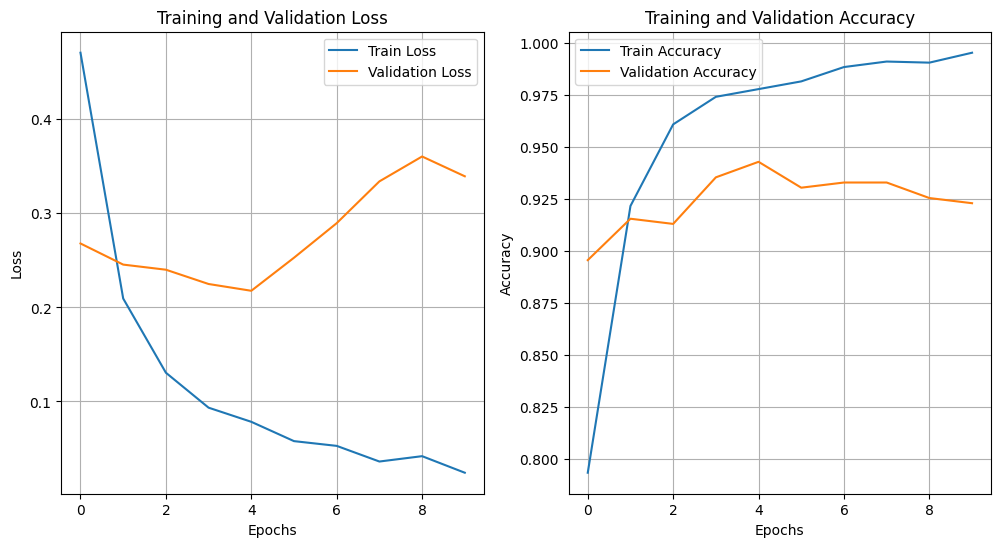

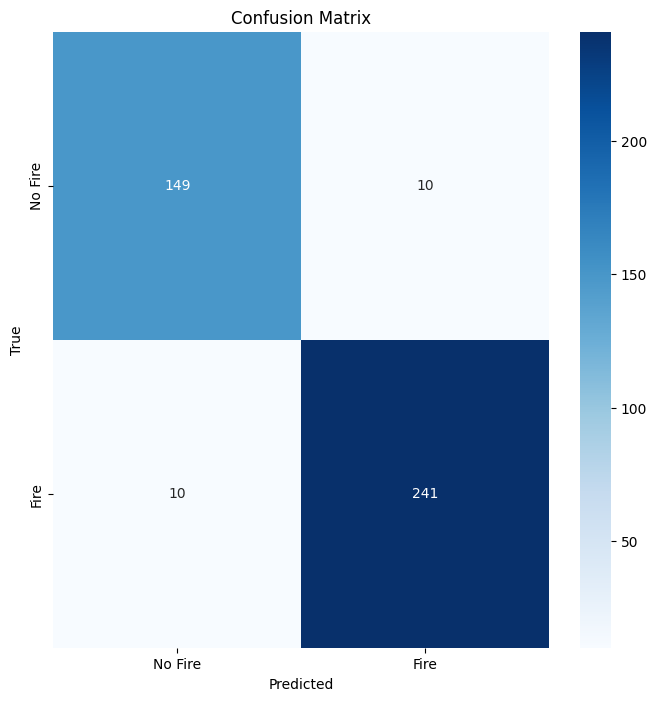

In [11]:
# Evaluation and Visualization
print("[INFO] Evaluating final model...")
metrics = evaluate_model(final_model, test_loader, ["No Fire", "Fire"], device, model_name="convnext_tiny", save_base_path="outputs/plots/tuned/convnexttiny")
# Training and Validation Curves
plot_training(history, f"outputs/plots/tuned/convnextnet_tuned_training_curve.png")

# Confusion Matrix
plot_confusion_matrix(
    cm=metrics["confusion_matrix"],
    classes=["No Fire", "Fire"],
    output_path=f"outputs/plots/tuned/convnextnet_tuned_confusion_matrix.png"
)

# Precision-Recall Curve
if "y_probs" in metrics:
    y_true = metrics["y_true"]
    y_probs = [prob[1] for prob in metrics["y_probs"]]
    plot_precision_recall(
        y_true=y_true,
        y_scores=y_probs,
        output_path=f"outputs/plots/tuned/convnextnet_tuned_precision_recall_curve.png"
    )

    # ROC Curve
    plot_roc_curve(
        y_true=y_true,
        y_scores=y_probs,
        output_path=f"outputs/plots/tuned/convnextnet_tuned_roc_curve.png"
    )

print("[INFO] All results saved successfully!")